# NUV-10 fs Time-Resolved Spectroscopy Results (2022 / 04 / 15) 

In [3]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import signal
from scipy.constants import h, c, e
from scipy.fft import fft,fft2,fftfreq,fftshift

import matplotlib
from matplotlib import cm
from matplotlib import rc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
matplotlib.rcParams.update({"text.usetex":False})
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["mathtext.rm"] = "Times New Roman"
matplotlib.rcParams["mathtext.it"] = "Times New Roman:italic"
matplotlib.rcParams["mathtext.bf"] = "Times New Roman:bold"
rc("font",**{"family":"Times New Roman"})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib_latex_bridge as mlb
import matplotlib.pyplot as plt
%matplotlib inline
import math
import tkinter as tk
from tkinter import filedialog

## Measurment information
Sample: DMSO.  
Scan: from -300 fs to 1800 fs.  
Scan step: 1 fs for 2000 pts.  
Scan loops: 5 loops for average. 

## Data import

### 1. dT and T import

In [4]:
class Dataimport:
    def result_import(self,data_name,transpose=True,reverse=False):
        dT_root = tk.Tk().withdraw()
        dT_file_path = filedialog.askopenfilename()      
        self.result_import = pd.read_table(dT_file_path,
                  sep="\t",
                  header=None,
                  dtype={'Name': str, 'Value': "double"},
                  encoding="big5",
                  float_precision="high"
                  )
        if transpose == True:
            result0 = self.result_import.transpose()
        else:
            result0 = self.result_import
        
        if reverse == True:
            result = result0.iloc[::-1].reset_index(drop=True)
        else:
            result = result0
        
        
        print("Imported ", data_name, "path:\n", dT_file_path)
        return result
    
    
    def mla_import(self):
        T_root = tk.Tk().withdraw()
        T_file_path = filedialog.askopenfilename()      
        print("Imported T path:\n", T_file_path)
        self.mla_import = pd.read_table(T_file_path,
                  sep="\t",
                  header=3,
                  dtype={'Name': str, 'Value': "double"},
                  encoding="big5"
                  )
        return self.mla_import

In [5]:
dT_b = Dataimport().result_import("dT backward scan", transpose=True, reverse=True)
dT_f = Dataimport().result_import("dT forward scan", transpose=True, reverse=False)
T = Dataimport().mla_import()

Imported  dT backward scan path:
 /Users/kentko/Library/Mobile Documents/com~apple~CloudDocs/研究資料/實驗數據/DMSO/20220308/20220308/DMSO +45-45/-200.10 1.00 2000.00   1/dT  -200.10 1.00 2000.00   5-ft scan-b
Imported  dT forward scan path:
 /Users/kentko/Library/Mobile Documents/com~apple~CloudDocs/研究資料/實驗數據/DMSO/20220308/20220308/DMSO +45-45/-200.10 1.00 2000.00   1/dT  -200.10 1.00 2000.00   5-ft scan-f
Imported T path:
 /Users/kentko/Library/Mobile Documents/com~apple~CloudDocs/研究資料/實驗數據/DMSO/20220308/20220308/DMSO +45-45/T@390 mn 100 mv td= 100ms +45 -45 dregee.mld


### 2. Wavelength and time calibration

In [6]:
# time array
time_array = pd.Series(np.linspace(-200,1800,2001))
# wavlength calibration
calibration_reference = pd.read_table("/Users/kentko/Library/Mobile Documents/com~apple~CloudDocs/研究資料/實驗數據/multi channel lockin amp calibration/Wavelength ref of multi ch lock in-96 ch.dat",
                                    sep="\t",
                                    header=0,
                                    dtype={'Name': str, 'Value': float})
wavelength = pd.Series(calibration_reference.loc[:,"390"]).transpose()
print("Time array and wavelength imported")

Time array and wavelength imported


## Data processing

In [431]:
def bg(input_data, mean_pts):
    """bg: remove the back ground noise of one dimensional array(onedim_data):
        select the 0 to "mean_pts" elements of 1D-array and take the average them to get  background signmal(bg),
        them return the reult of 1D-array-bg""" 
    # get the average value of selected range
    bg_signal = np.mean(input_data[0:mean_pts])                                                                
    # remove the background 
    bg_result = input_data-bg_signal                                                                            
    return bg_result


def smooth_filter(input_data,t_step,smooth_pts,filtertype):
    """smooth_hass: smooth the input data by take average of each element, for select smooth length "s"
       the smooth result of n th element is taking average from (n-s/2)-th to (n+s/2) th elements. """                                                                                    #create a 2d array
    s = int(smooth_pts/2)     
    w = len(input_data.transpose())
    l = len(input_data)
    smoothed_array = []
    for i in range(l):
        smoothed_array_col = []
        for j in range(w):
            if 0<= i < s:
                smoothed_pt = np.mean(input_data.iloc[0:2*i+1,j])

            elif s <= i <= l-s:
                smoothed_pt = np.mean(input_data.iloc[i-s:i+s,j])

            else:
                smoothed_pt = np.mean(input_data.iloc[i-(l-i)+1:l,j])
            smoothed_array_col.append(smoothed_pt)
        smoothed_array.append(smoothed_array_col)
    cutoff = 33356.68/(smooth_pts*t_step)
    print("The cutoff frequency =", round(cutoff,4), "cm-1")
    smoothed_result = pd.DataFrame(smoothed_array)
    
    #select the high-pass and low-pass filter
    if filtertype == "high_pass": 
        return input_data-smoothed_result
    
    elif filtertype == "low_pass":
        return smoothed_result
    
    else:# if not tpye,return the high-pass result 
        return input_data-smoothed_result
    

def add_window(input_data, zero_pt, t_step, start_pt, fft_number, window_function):
    """Apply the window function"""
    # transform the start and the end time
    start_ffttime = (start_pt-zero_pt)*t_step
    print("The selected start point of 2D FFT is ", start_ffttime, "fs")
    end_ffttime = (fft_number+start_pt-zero_pt)*t_step
    print("The selected end point of 2D FFT is ", end_ffttime, "fs")
    
    
    # Set the length of window function, not to over the length of input array
    if  start_pt+fft_number <= len(input_data):
        window_length = fft_number
    else:
        window_length = len(input_data)-start_pt
    
    window = signal.get_window(window_function, window_length)
    print("The selected window function is", window_function)
    
    windowed_data = (input_data.iloc[start_pt:start_pt+fft_number,:].transpose()*window/0.42).transpose()
    return pd.DataFrame(windowed_data)
    
    
def append0(input_data, t_step, apd0range_order):    
    """ add 0 into input data array to 2**n points """
    wavenumber_pitch = 33356/(t_step*(2**apd0range_order))
    print("The wavenumber pitch =", round(wavenumber_pitch, 4), "cm-1")
    pad_result = np.pad(input_data, ((0,2**apd0range_order-len(input_data)),(0,0)),"constant")
    return pd.DataFrame(pad_result)


def FFT_process(input_data, t_step, zero_pt, start_pt):
    """Input a 2D dA data and do the FFT among the time axis, and output the FFT result """ 
    # Get the number of sample points
    N = len(input_data)
    # Sample spacing
    T = t_step
    time_array = np.linspace(0,N*T,N,endpoint=False)
    FFT_result_2sides = fft(input_data.transpose()).transpose()
    
    # Take the one side FFT process (from 0 to the total length of input data)
    oneside_FFT_length = N/2+N%2   # Get the one side FFT length
    wavenumber_array = pd.Series(fftfreq(N,T)[:N//2]*N/2) # Get the wavenumber_array
    
    complexed_FFT_result0 = FFT_result_2sides[0:int(oneside_FFT_length),:] # The result of one side FFT 
    firstpt_reusLt0 = complexed_FFT_result0[0]/np.sqrt(2)
    complexed_FFT_result0[0] = firstpt_reusLt0
    complexed_FFT_result = complexed_FFT_result0*(np.sqrt(2)/complex(N,0))
    
    
    
    #display(complexed_FFT_result[:,50])
    #complexed_FFT_result = complexed_FFT_result0*(np.sqrt(2)/complex(length,0)
    real_result = (complexed_FFT_result).real
    imag_result = (complexed_FFT_result).imag
    
    # Power intensity of FFT
    mag_result = pd.DataFrame(np.sqrt(real_result**2+imag_result**2))

    # phase of FFT result
    phase_result = pd.DataFrame(np.arctan2(imag_result,real_result))
    #output_phase = []
    #for p in range(len(phase_result)):
    #    output_phase0 = ((np.pi/len(phase_result)*p*(zero_pt-start_pt))+phase_result.transpose()[p]+np.pi)%(2*np.pi)-np.pi
    #output_phase.append(output_phase0)    
    

    return wavenumber_array, complexed_FFT_result, mag_result, phase_result

### 1. dT transfer to dA

In [85]:
dT_B_bg = bg(dT_b,20)
dT_F_bg = bg(dT_f,20)
dA_B_bg = -np.log10(1+dT_B_bg/T.loc[:,"X1"])
dA_F_bg = -np.log10(1+dT_F_bg/T.loc[:,"X1"])

### 2. dA transfer to dA-FFT

In [51]:
zero_pt = 200
t_step = 0.99
start_pt = 400
fft_number = 1000
smooth_pts = 500

#### (1). Smooth the dA

In [52]:
dA_B_bg_sm = smooth_filter(100000*dA_B_bg, t_step,smooth_pts, "high_pass")

The cutoff frequency = 67.3872 cm-1


#### (2). Add window

In [80]:
dA_B_bg_sm_aw = add_window(dA_B_bg_sm, zero_pt, t_step, start_pt, fft_number, "blackman")

The selected start point of 2D FFT is  198.0 fs
The selected end point of 2D FFT is  1188.0 fs
The selected window function is blackman


#### (3). Pad 0 to n order of 2

In [81]:
dA_B_bg_sm_aw_pad0 = append0(dA_B_bg_sm_aw, t_step, 16)

The wavenumber pitch = 0.5141 cm-1


In [408]:
#FFT_wavenumber_array=np.linspace(0,0.5141*32768,32768,endpoint=False)
dA_FFT = FFT_process(dA_B_bg_sm_aw_pad0, 0.99,200,400)
wavenumber_array = dA_FFT[0]
dA_FFT_result = dA_FFT[2]

(0.0, 5.0)

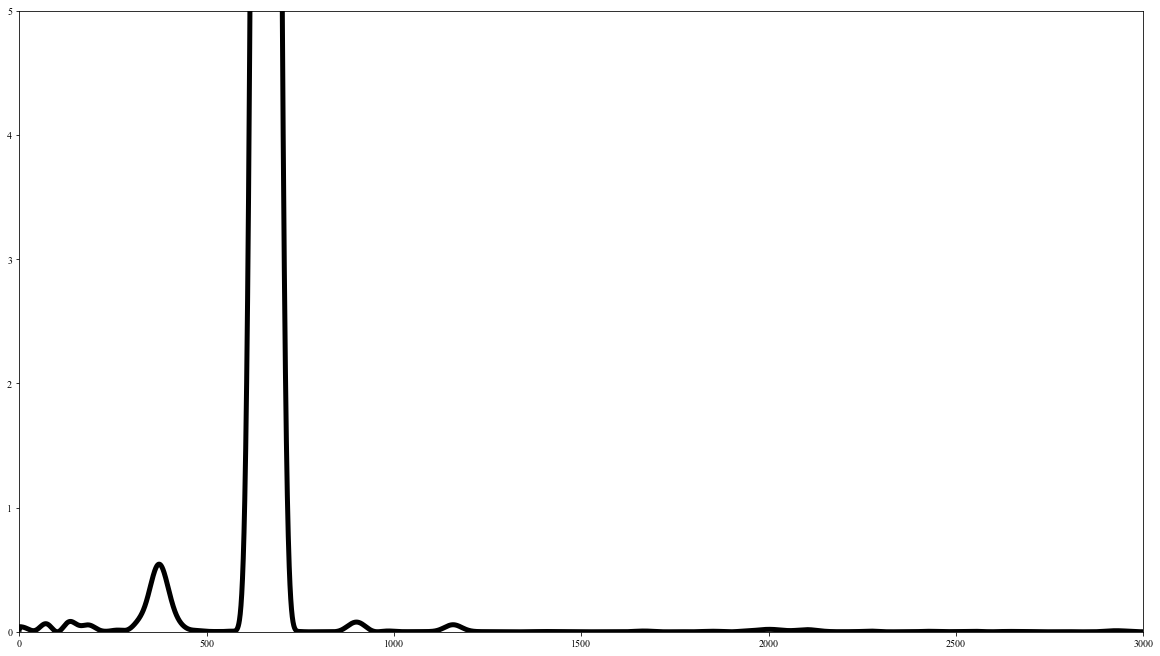

In [363]:
fig1,ax1 = plt.subplots(constrained_layout=True, figsize=(16,9))       
curve1 = ax1.plot(wavenumber_array, np.abs(dA_FFT_result.iloc[:,67])**2, linewidth=5, color="black",label="Ferous Cyt " "$c$")
x_min, x_max=0, 3000
x_sticklength=5
x_sticknumber = int((x_max-x_min)/x_sticklength+1)
ax1.set_xlim(x_min,x_max)
y_min, y_max=0, 5
y_sticklength=1
y_sticknumber = int((y_max-y_min)/y_sticklength+1)
ax1.set_ylim(y_min,y_max)

(0.0, 3000.0)

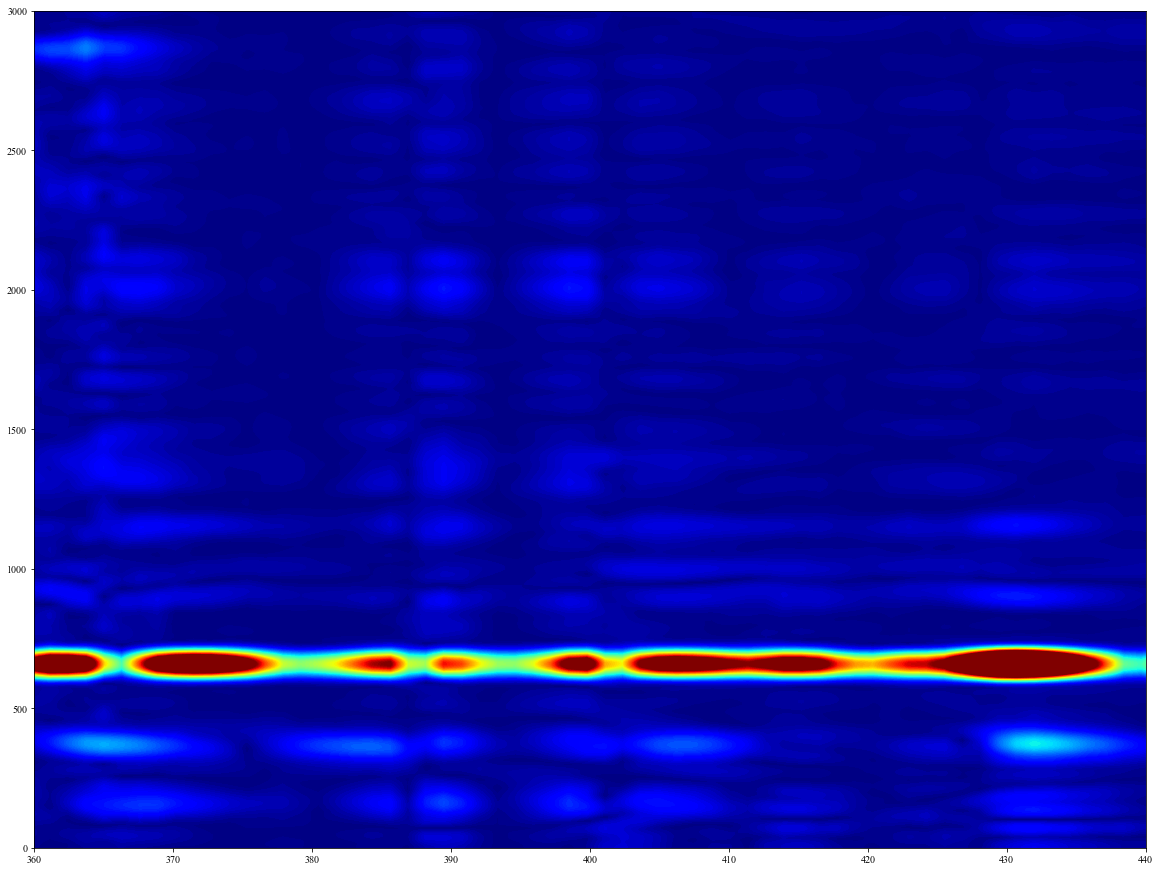

In [358]:
color_levels=np.linspace(0,2,101) 
fig1,ax1=plt.subplots(constrained_layout=True, figsize=(16,12))       
ax1.contourf(wavelength,wavenumber_array,dA_FFT_result,color_levels, cmap="jet",extend="both")
#=====================#
# Plot setting-x and y axis #
#=====================#
x_min, x_max=360, 440
x_sticklength=5
x_sticknumber=int((x_max-x_min)/x_sticklength+1)
ax1.set_xlim(x_min,x_max)
y_min,y_max=0,3000
y_sticklength=100
y_sticknumber=int((y_max-y_min)/y_sticklength+1)
ax1.set_ylim(y_min,y_max)

## Results plots
### 1.dA results of sample

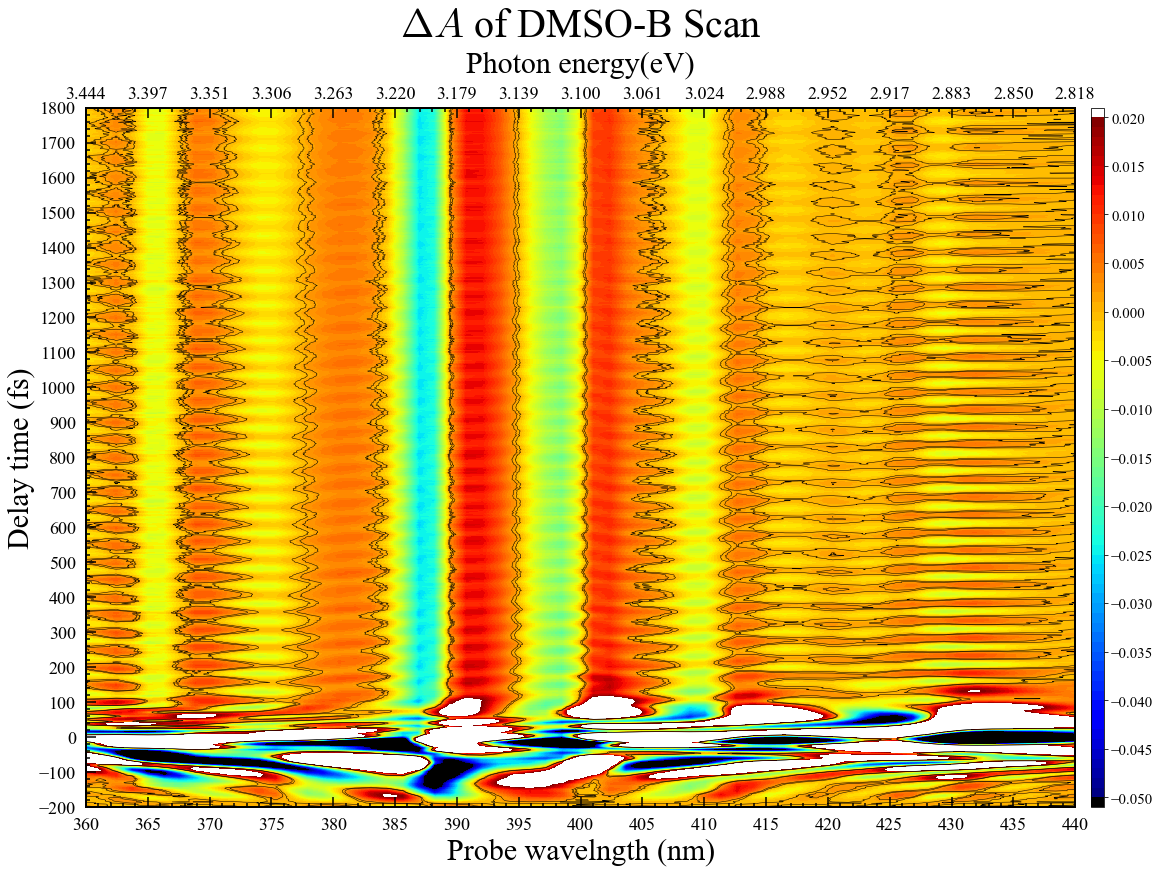

In [359]:
fig1,ax1 = plt.subplots(constrained_layout=True, figsize=(16,12))                                     # set the width and height of figure in 16/12 inchs
ax1.spines["top"].set_linewidth(2)
ax1.spines["left"].set_linewidth(2)
ax1.spines["bottom"].set_linewidth(2)
ax1.spines["right"].set_linewidth(2)                                                                  # set the linewidth of frame 

color_levels=np.linspace(-0.05,0.02,71)                                                               # set the levels of color map
#np.linspace(0.8*signal.min(),0.8*signal.max(),int((signal.max()-signal.min())/0.01))                                                                                                   
SP=ax1.contourf(wavelength, time_array, dA_B_bg, color_levels, cmap="jet",extend="both")
SP_line=plt.contour(wavelength, time_array, dA_B_bg,levels=(0,0.0015),linestyles="solid", colors="black",linewidths=0.5)
SP.cmap=plt.cm.get_cmap("jet").copy()
#SP.cmap.extendrect=True
SP.cmap.set_over("white")
SP.cmap.set_under("black")
plt.rc("csfont")
plt.gca

#====================#
# Plot setting-title #
#====================#
plt.title("$\Delta \it{A}$" " of DMSO-B Scan",fontdict={"family":"Times New Roman","size":40},pad=15)
plt.xlabel("Probe wavelngth (nm)",fontdict={"size":30})
plt.ylabel("Delay time (fs)",fontdict={"size":30})

#=====================#
# Plot setting-x axis #
#=====================#
x_min, x_max=360, 440
x_sticklength=5
x_sticknumber=int((x_max-x_min)/x_sticklength+1)
ax1.set_xlim(x_min,x_max)
x_wavelength=np.linspace(x_min,x_max,x_sticknumber,endpoint=True)
ax1.set_xticks(x_wavelength)
ax1.xaxis.set_tick_params(which="major",direction="in",top="on",length=10,width=1.5,pad=10,labelsize=18)
ax1.xaxis.get_ticklocs(minor=True)   
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_tick_params(which="minor", bottom=True,top="on",direction="in",length=4,width=1.5)

#=====================#
# Plot setting-y axis #
#=====================#
y_min,y_max=-200,1800
y_sticklength=100
y_sticknumber=int((y_max-y_min)/y_sticklength+1)
ax1.set_ylim(y_min,y_max)
ax1.yaxis.set_ticks(np.linspace(y_min,y_max,y_sticknumber))  
ax1.yaxis.set_tick_params(direction="in",length=10,width=1.5,pad=10,labelsize=18)
ax1.yaxis.get_ticklocs(minor=True)   
ax1.yaxis.set_minor_locator(MultipleLocator(20))
ax1.yaxis.set_tick_params(which="minor", left=True,direction="in",length=4,width=1.5)

#===============================#
# Plot setting-secondary x axis #
#===============================#
x_photon_energy=(h*c/e)/(x_wavelength*10**(-9))
def photon_energy(wavelength):
    np.seterr(divide="ignore")
    return (h*c/e)/(wavelength*10**(-9))
def inverse(x2):
    return np.round(x2*(10**9)/(h*c/e),2)
secax=ax1.secondary_xaxis("top", functions=(photon_energy, photon_energy))
secax.set_xlabel("Photon energy(eV)",labelpad=15,fontdict={"size":30})
secax.set_xticks(x_photon_energy)
secax.tick_params(axis="x",which="major",direction="in",top="on",labeltop=True,length=10,width=1.5,pad=5,labelsize=18)
secax.xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
#secax.minorticks_on
#secax.xaxis.set_minor_locator(MultipleLocator(5))
#secax.xaxis.set_tick_params(which='minor', bottom=True,direction="in",length=4,width=1.5)

#===============================#
# Plot setting-colcrbar setting #
#===============================#
cbar_min,cbar_max=-0.05, 0.02
cbar_level=15
cbar_ticks=np.linspace(cbar_min,                            # min of color bar
                       cbar_max,                            # max of color bar
                       cbar_level,                          
                       endpoint=True)           
cbar=fig1.colorbar(SP,ax=ax1,aspect=50,ticks=cbar_ticks,pad=-0.005,extendrect=True,extendfrac="auto")
#cbar.ax.set_title("Intensity",loc="left",pad=-0.1,fontdict={"size":15})
cbar.ax.tick_params(labelsize=15)
plt.savefig("fig1.jpg",dpi=300)
plt.show()

### 2. 2D FFT result of sample

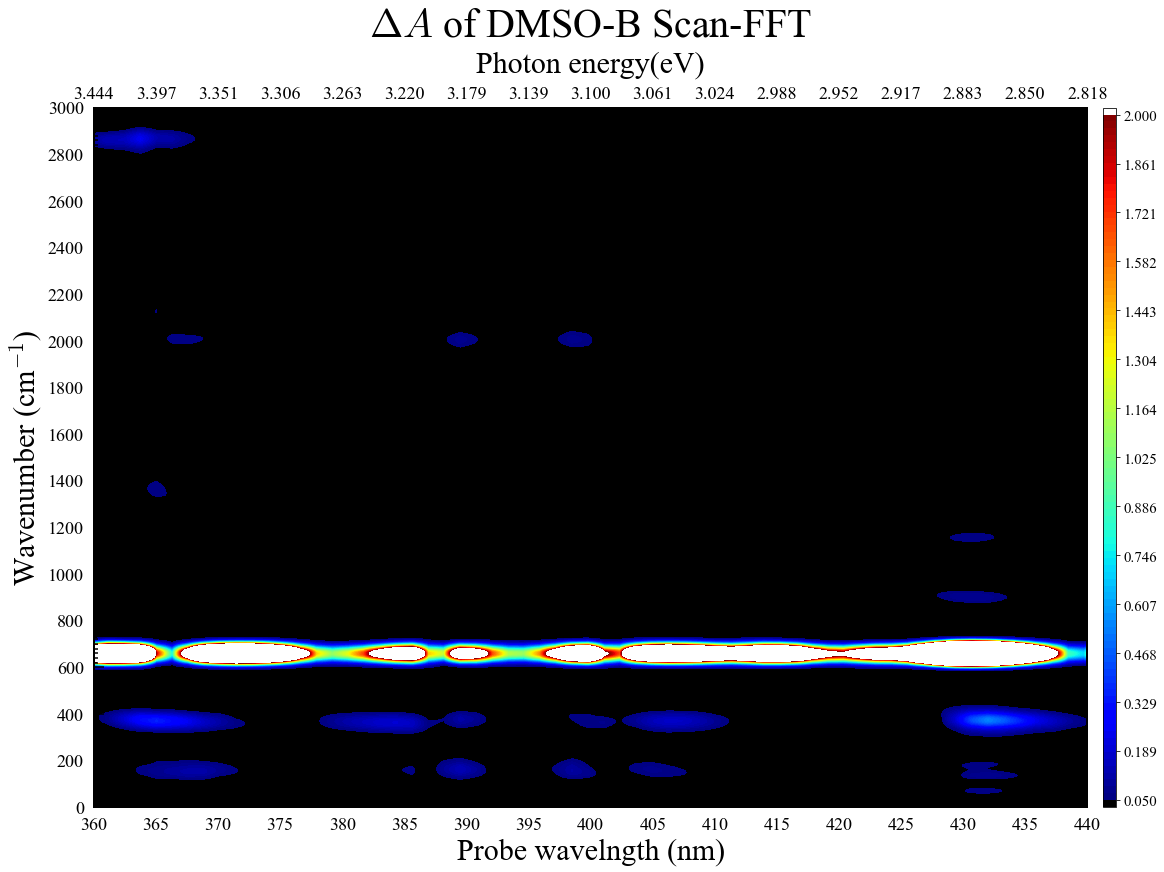

In [360]:
fig1,ax1 = plt.subplots(constrained_layout=True, figsize=(16,12))                                   # set the width and height of figure in 16/12 inchs
for arg in ("top", "bottom", "left", "right"):
    ax1.spines[arg].set_linewidth(2)

# ax1.spines["top"].set_linewidth(2)
# ax1.spines["left"].set_linewidth(2)
# ax1.spines["bottom"].set_linewidth(2)
# ax1.spines["right"].set_linewidth(2)                                                                  # set the linewidth of frame 

color_levels=np.linspace(0.05,2,100)                                                               # set the levels of color map
#np.linspace(0.8*signal.min(),0.8*signal.max(),int((signal.max()-signal.min())/0.01))                                                                                                   
SP=ax1.contourf(wavelength, wavenumber_array, np.abs(dA_FFT_result)**2, color_levels, cmap="jet",extend="both")
SP.cmap=plt.cm.get_cmap("jet").copy()
#SP.cmap.extendrect=True
SP.cmap.set_over("white")
SP.cmap.set_under("black")
plt.rc("csfont")
plt.gca

#====================#
# Plot setting-title #
#====================#
plt.title("$\Delta \it{A}$" " of DMSO-B Scan-FFT",fontdict={"family":"Times New Roman","size":40},pad=15)
plt.xlabel("Probe wavelngth (nm)",fontdict={"size":30})
plt.ylabel("Wavenumber (cm$^{-1}$)",fontdict={"size":30})

#=====================#
# Plot setting-x axis #
#=====================#
x_min, x_max=360, 440
x_sticklength=5
x_sticknumber=int((x_max-x_min)/x_sticklength+1)
ax1.set_xlim(x_min,x_max)
x_wavelength=np.linspace(x_min,x_max,x_sticknumber,endpoint=True)
ax1.set_xticks(x_wavelength)
ax1.xaxis.set_tick_params(which="major",direction="in",top="on",length=10,width=1.5,pad=10,labelsize=18)
ax1.xaxis.get_ticklocs(minor=True)   
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_tick_params(which="minor", bottom=True,top="on",direction="in",length=4,width=1.5)

#=====================#
# Plot setting-y axis #
#=====================#
y_min,y_max=0,3000
y_sticklength=200
y_sticknumber=int((y_max-y_min)/y_sticklength+1)
ax1.set_ylim(y_min,y_max)
ax1.yaxis.set_ticks(np.linspace(y_min,y_max,y_sticknumber))  
ax1.yaxis.set_tick_params(direction="in",length=10,width=1.5,pad=10,labelsize=18)
ax1.yaxis.get_ticklocs(minor=True)   
ax1.yaxis.set_minor_locator(MultipleLocator(20))
ax1.yaxis.set_tick_params(which="minor", left=True,direction="in",length=4,width=1.5)

#===============================#
# Plot setting-secondary x axis #
#===============================#
x_photon_energy=(h*c/e)/(x_wavelength*10**(-9))

def photon_energy(wavelength):
    np.seterr(divide="ignore")
    return (h*c/e)/(wavelength*10**(-9))

def inverse(x2):
    return np.round(x2*(10**9)/(h*c/e),2)

secax = ax1.secondary_xaxis("top", functions=(photon_energy, photon_energy))
secax.set_xlabel("Photon energy(eV)", labelpad=15, fontdict={"size": 30})
secax.set_xticks(x_photon_energy)
secax.tick_params(axis="x", which="major", direction="in", top="on", labeltop=True,
                  length=10, width=1.5, pad=5, labelsize=18)
secax.xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
#secax.minorticks_on
#secax.xaxis.set_minor_locator(MultipleLocator(5))
#secax.xaxis.set_tick_params(which='minor', bottom=True,direction="in",length=4,width=1.5)

#===============================#
# Plot setting-colcrbar setting #
#===============================#
cbar_min, cbar_max = 0.05, 2
cbar_level = 15
cbar_ticks = np.linspace(cbar_min,                            # min of color bar
                       cbar_max,                            # max of color bar
                       cbar_level,                          
                       endpoint=True)           
cbar = fig1.colorbar(SP,ax=ax1,aspect=50,ticks=cbar_ticks,pad=-0.005,extendrect=True,extendfrac="auto")
#cbar.ax.set_title("Intensity",loc="left",pad=-0.1,fontdict={"size":15})
cbar.ax.tick_params(labelsize=15)
plt.savefig("fig2.jpg",dpi=300)
plt.show()

In [433]:
test= pd.DataFrame([[1 for i in range(96)] for m in range(2001)])
test_aw = add_window(test, 0, 0.99, 0, 2001, "blackman")
test_ap0 = append0(test_aw, 0.99, 16)
test_fft = FFT_process(test_ap0 ,0.99,0,0)
#display(pd.DataFrame(test_fft[0]))

The selected start point of 2D FFT is  0.0 fs
The selected end point of 2D FFT is  1980.99 fs
The selected window function is blackman
The wavenumber pitch = 0.5141 cm-1


(0.0, 0.05)

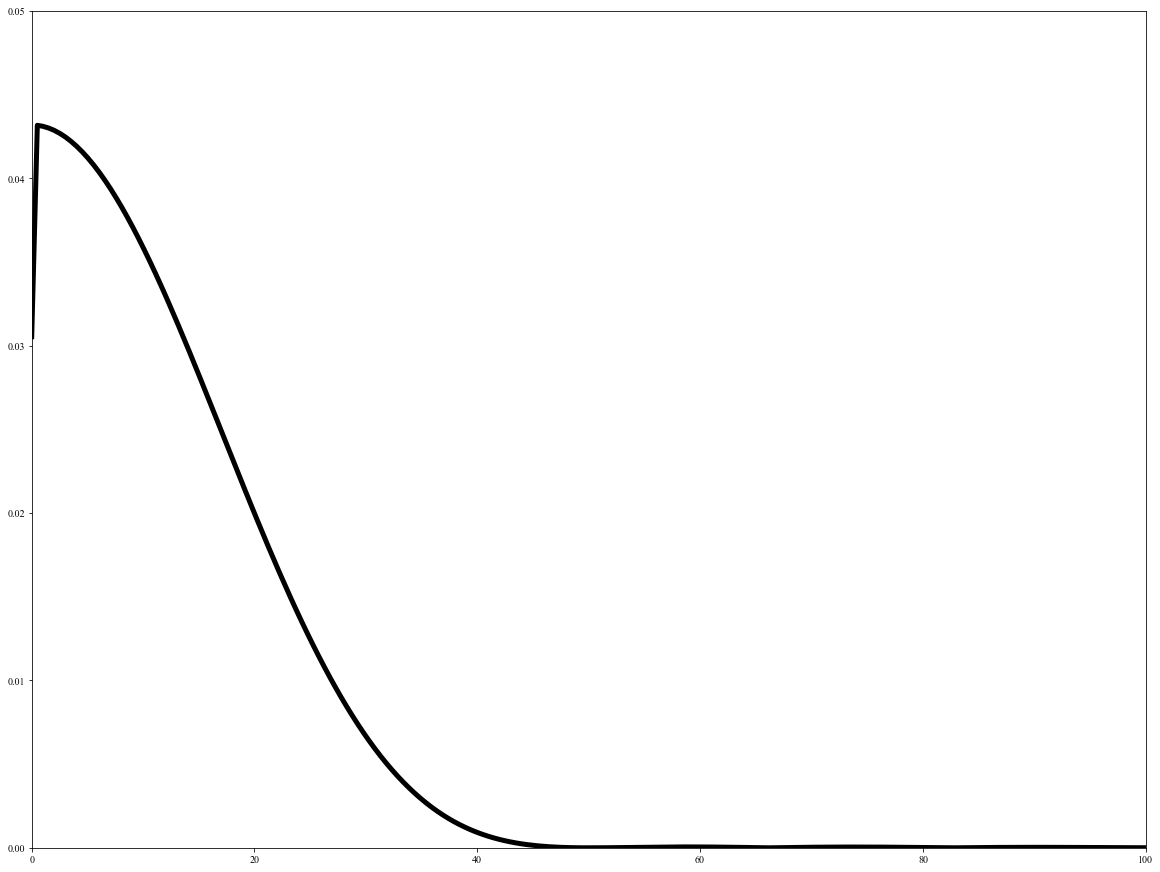

In [436]:
fig1,ax1 = plt.subplots(constrained_layout=True, figsize=(16,12))       
curve1 = ax1.plot(test_fft[0], test_fft[2].iloc[:,50], linewidth=5, color="black",label="Ferous Cyt " "$c$")
x_min, x_max=0, 100
x_sticklength=5
x_sticknumber = int((x_max-x_min)/x_sticklength+1)
ax1.set_xlim(x_min,x_max)
y_min, y_max=0, 0.05
y_sticklength=1
y_sticknumber = int((y_max-y_min)/y_sticklength+1)
ax1.set_ylim(y_min,y_max)